# Sprint 04 de Data Science — Classificação e Regressão

**Integrantes:**
1. Arthur Bobadilla Franchi - RM555056
2. Arthur Albuquerque Menezes - RM562950
3. Caio Rasuck Barbosa - RM93645
4. Luan Orlandelli Ramos - RM554747
5. Jorge Luiz - RM554418

**Tema do caso:** predição de **atraso na entrega de laudos** em um centro de diagnóstico por imagem.

**Conteúdo:**
1. Definição do problema de predição binária  
2. KNN + justificativa do `k`  
3. Avaliação (acurácia, precisão, recall, F1)  
4. Regressão Logística (probabilidade + interpretação de coeficientes)  
5. Comparação de resultados  
6. Ridge (problema contínuo)  
7. Lasso (seleção de variáveis)  
8. Regressão Polinomial (grau 2)  
9. Árvore de Decisão e Random Forest  
10. Recomendação final (relatório executivo)



In [11]:
import sys, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import sklearn
    from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
    from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score, classification_report,
        confusion_matrix, roc_auc_score, RocCurveDisplay
    )
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
except Exception as e:
    raise ImportError("Este notebook requer scikit-learn. Instale com `pip install scikit-learn`.")

np.random.seed(42)
plt.style.use('seaborn-v0_8')


## 2) Definição do problema e geração de dados

**Problema binário:** prever se haverá **atraso na entrega do laudo** (`atraso = 1`) ou não (`atraso = 0`).

**Variáveis explicativas:**
- `volume_exames_dia` (quantidade diária)
- `carga_trabalho_medico` (índice)
- `hora_coleta` (hora do dia)
- `complexidade_exame` (1 a 3)
- `backlog_atual` (fila em aberto)
- `indisp_sistema` (0/1)
- `experiencia_tecnico` (anos)
- `recurso_disponivel` (0/1)
- `distancia_unidade_km`
- `dia_semana` (0=Seg, ..., 6=Dom)
- `chuva` (0/1)
- `feriado` (0/1)

**Alvo contínuo:** `tempo_total_min`


In [2]:
# Geração de dados sintéticos
n = 5000

# Variáveis básicas
dia_semana = np.random.randint(0, 7, size=n)
hora_coleta = np.random.randint(6, 22, size=n)
complexidade_exame = np.random.choice([1,2,3], size=n, p=[0.5, 0.35, 0.15])
chuva = np.random.binomial(1, 0.3, size=n)
feriado = (np.random.binomial(1, 0.07, size=n) * (dia_semana<=5)).astype(int)

# Volume com efeito do dia da semana (Seg e Ter mais cheios)
mult_dia = np.array([1.2, 1.15, 1.0, 0.95, 1.05, 0.7, 0.6])
volume_exames_dia = np.random.poisson(lam=(25 * mult_dia[dia_semana])).astype(float)

# Backlog correlacionado com volume e dia
backlog_atual = np.clip(np.random.poisson(lam=(8 * mult_dia[dia_semana]) + 0.15*volume_exames_dia), 0, None)

# Indisponibilidade de sistema
indisp_sistema = np.random.binomial(1, 0.05, size=n)

# Experiência e recurso disponível
experiencia_tecnico = np.round(np.random.gamma(shape=2.0, scale=2.0, size=n), 1)
recurso_disponivel = np.random.binomial(1, 0.8, size=n)

# Distância da unidade
distancia_unidade_km = np.round(np.random.exponential(scale=5.0, size=n), 2)

# Carga de trabalho médico correlacionada
carga_trabalho_medico = (
    0.5*volume_exames_dia +
    2.0*complexidade_exame +
    1.0*backlog_atual +
    5.0*indisp_sistema +
    0.3*hora_coleta +
    np.random.normal(0, 5, size=n)
)

# Probabilidade de atraso
logit = (
    -4.0
    + 0.04*volume_exames_dia
    + 0.09*backlog_atual
    + 1.8*indisp_sistema
    - 0.12*experiencia_tecnico
    - 0.9*recurso_disponivel
    + 0.06*distancia_unidade_km
    + 0.35*complexidade_exame
    + 0.45*chuva
    + 0.8*feriado
    + 0.03*hora_coleta
    + np.array([0.2, 0.15, 0.0, 0.0, 0.1, -0.1, -0.15])[dia_semana]
)

p_atraso = 1 / (1 + np.exp(-logit))
atraso = np.random.binomial(1, p_atraso)

# Variável contínua
tempo_total_min = (
    20
    + 0.8*volume_exames_dia
    + 1.5*backlog_atual
    + 18*indisp_sistema
    - 0.9*experiencia_tecnico
    - 8*recurso_disponivel
    + 0.6*distancia_unidade_km
    + 3.5*complexidade_exame
    + 4*chuva
    + 9*feriado
    + 0.7*hora_coleta
    + np.array([2, 1.5, 0, 0, 1, -1, -1.5])[dia_semana]
    + np.random.normal(0, 10, size=n)
)

df = pd.DataFrame({
    'volume_exames_dia': volume_exames_dia,
    'carga_trabalho_medico': carga_trabalho_medico,
    'hora_coleta': hora_coleta,
    'complexidade_exame': complexidade_exame,
    'backlog_atual': backlog_atual,
    'indisp_sistema': indisp_sistema,
    'experiencia_tecnico': experiencia_tecnico,
    'recurso_disponivel': recurso_disponivel,
    'distancia_unidade_km': distancia_unidade_km,
    'dia_semana': dia_semana,
    'chuva': chuva,
    'feriado': feriado,
    'atraso': atraso,
    'tempo_total_min': tempo_total_min
})

print(df.head())
print("Balanceamento da classe 'atraso':", df['atraso'].value_counts(normalize=True).round(3))


   volume_exames_dia  carga_trabalho_medico  hora_coleta  complexidade_exame  \
0               18.0              16.413721           12                   2   
1               25.0              30.255934           16                   3   
2               20.0              27.051385           15                   2   
3                8.0              16.208933           19                   1   
4               21.0              25.344888            6                   2   

   backlog_atual  indisp_sistema  experiencia_tecnico  recurso_disponivel  \
0              8               0                  2.9                   1   
1              4               0                  1.2                   0   
2             10               0                  6.6                   1   
3              7               0                  3.6                   1   
4             12               0                  0.8                   0   

   distancia_unidade_km  dia_semana  chuva  feriado  atr

## 3) Separação treino/teste (Classificação) e pré-processamento

- `dia_semana` será codificada.
- Variáveis tratadas como numéricas.
- Será aplicado `StandardScaler` especialmente para KNN e Regressão Logística.


In [12]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

features_cls = [
    'volume_exames_dia','carga_trabalho_medico','hora_coleta','complexidade_exame',
    'backlog_atual','indisp_sistema','experiencia_tecnico','recurso_disponivel',
    'distancia_unidade_km','dia_semana','chuva','feriado'
]
X = df[features_cls]
y = df['atraso']

cat_cols = ['dia_semana']
num_cols = [c for c in features_cls if c not in cat_cols]

preprocess = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

n_train = X_train.shape[0]
print(f"Tamanho do treino: {n_train}, teste: {X_test.shape[0]}")


Tamanho do treino: 4000, teste: 1000


## 4) KNN — Treino, escolha de `k` e justificativa

- Regra de bolso: `k ≈ sqrt(n_treino)` → ajuda a suavizar ruído.
- Escolha final via **validação cruzada estratificada** otimizando **F1-score**.


Regra de bolso: k ~ sqrt(4000) = 63
Melhores parâmetros: {'clf__n_neighbors': 5}
F1 médio (CV): 0.3192
Acurácia: 0.782 | Precisão: 0.392 | Recall: 0.193 | F1: 0.259 | ROC-AUC: 0.628


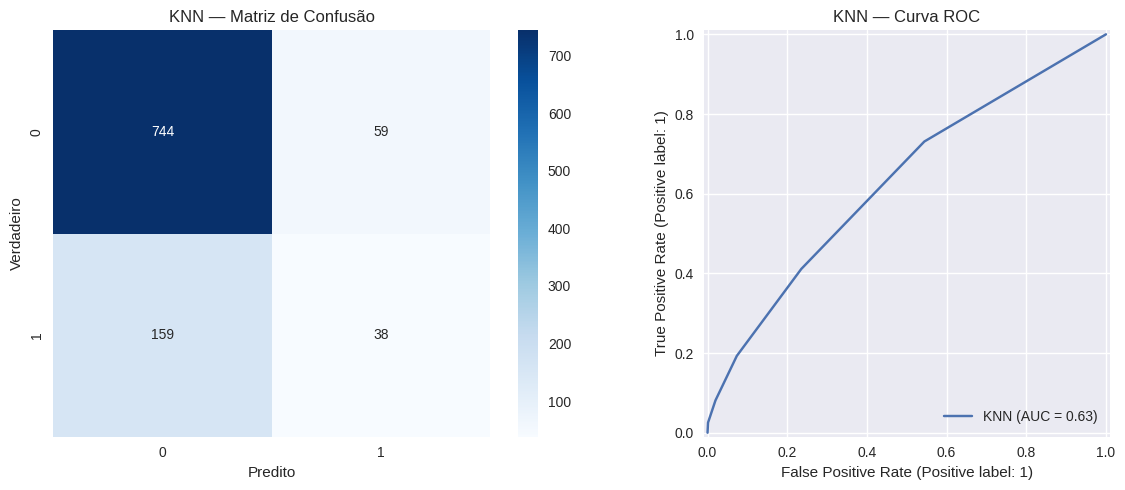

In [13]:

import math
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay

est_k = int(math.sqrt(n_train))
print(f"Regra de bolso: k ~ sqrt({n_train}) = {est_k}")

param_grid = { 'clf__n_neighbors': [3,5,7,9,11,15,21,31,41,est_k] }
knn = Pipeline(steps=[('prep', preprocess), ('clf', KNeighborsClassifier())])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_grid = GridSearchCV(knn, param_grid, scoring='f1', cv=cv, n_jobs=-1, verbose=0)
knn_grid.fit(X_train, y_train)

print("Melhores parâmetros:", knn_grid.best_params_)
print("F1 médio (CV):", round(knn_grid.best_score_, 4))

best_knn = knn_grid.best_estimator_

# Avaliação no teste
pred_knn = best_knn.predict(X_test)
proba_knn = best_knn.predict_proba(X_test)[:,1]

acc_knn = accuracy_score(y_test, pred_knn)
prec_knn = precision_score(y_test, pred_knn)
rec_knn = recall_score(y_test, pred_knn)
f1_knn = f1_score(y_test, pred_knn)
auc_knn = roc_auc_score(y_test, proba_knn)

print(f"Acurácia: {acc_knn:.3f} | Precisão: {prec_knn:.3f} | Recall: {rec_knn:.3f} | F1: {f1_knn:.3f} | ROC-AUC: {auc_knn:.3f}")

cm_knn = confusion_matrix(y_test, pred_knn)
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('KNN — Matriz de Confusão')
ax[0].set_xlabel('Predito')
ax[0].set_ylabel('Verdadeiro')

RocCurveDisplay.from_predictions(y_test, proba_knn, name='KNN', ax=ax[1])
ax[1].set_title('KNN — Curva ROC')
plt.tight_layout()
plt.show()


## 5) Regressão Logística — Probabilidade e interpretação dos coeficientes

A Regressão Logística fornece coeficientes interpretáveis: cada coeficiente representa a variação no **log-odds** de atraso para uma unidade de aumento da variável. Também apresentamos os **odds ratios** (`exp(coef)`).


Melhores parâmetros LR: {'clf__C': 10.0}
Acurácia: 0.813 | Precisão: 0.571 | Recall: 0.203 | F1: 0.300 | ROC-AUC: 0.727
 Relatório de Classificação (LR):               precision    recall  f1-score   support

           0       0.83      0.96      0.89       803
           1       0.57      0.20      0.30       197

    accuracy                           0.81      1000
   macro avg       0.70      0.58      0.60      1000
weighted avg       0.78      0.81      0.78      1000

Top 10 variáveis que mais aumentam o risco (LR):
                 variavel  coef_log_odds  odds_ratio
8    distancia_unidade_km       0.397326    1.487840
5          indisp_sistema       0.363522    1.438386
4           backlog_atual       0.360589    1.434173
9                   chuva       0.279624    1.322632
0       volume_exames_dia       0.219486    1.245436
10                feriado       0.216392    1.241590
3      complexidade_exame       0.174179    1.190269
1   carga_trabalho_medico       0.169053    1.

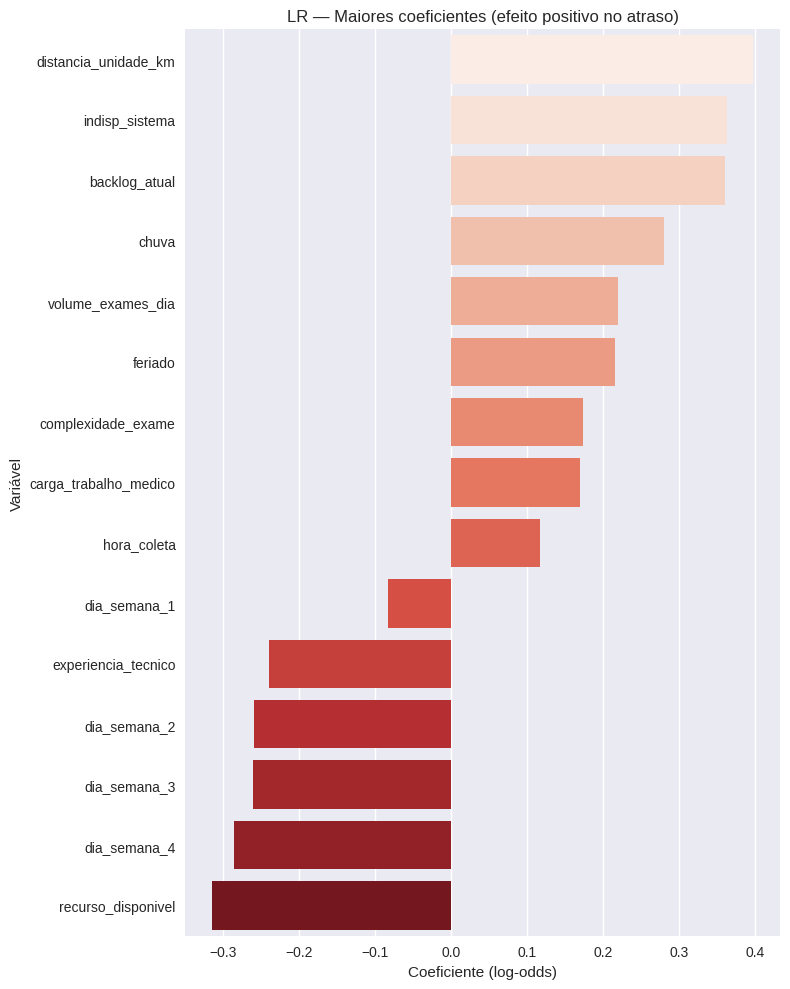

In [14]:

from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=200, solver='lbfgs'))
])

param_grid_lr = { 'clf__C': [0.01, 0.1, 1.0, 10.0] }
log_grid = GridSearchCV(log_reg, param_grid_lr, scoring='f1', cv=cv, n_jobs=-1)
log_grid.fit(X_train, y_train)

best_log = log_grid.best_estimator_
print("Melhores parâmetros LR:", log_grid.best_params_)

pred_lr = best_log.predict(X_test)
proba_lr = best_log.predict_proba(X_test)[:,1]

acc_lr = accuracy_score(y_test, pred_lr)
prec_lr = precision_score(y_test, pred_lr)
rec_lr = recall_score(y_test, pred_lr)
f1_lr = f1_score(y_test, pred_lr)
auc_lr = roc_auc_score(y_test, proba_lr)

print(f"Acurácia: {acc_lr:.3f} | Precisão: {prec_lr:.3f} | Recall: {rec_lr:.3f} | F1: {f1_lr:.3f} | ROC-AUC: {auc_lr:.3f}")
print(" Relatório de Classificação (LR):", classification_report(y_test, pred_lr))

# Interpretação dos coeficientes
enc = best_log.named_steps['prep']
num_names = enc.transformers_[0][2]
cat_encoder = enc.transformers_[1][1]
cat_in = enc.transformers_[1][2]
cat_names = list(cat_encoder.get_feature_names_out(cat_in))
all_feature_names = list(num_names) + cat_names

coefs = best_log.named_steps['clf'].coef_.ravel()
interp = pd.DataFrame({
    'variavel': all_feature_names,
    'coef_log_odds': coefs,
    'odds_ratio': np.exp(coefs)
}).sort_values('coef_log_odds', ascending=False)

print("Top 10 variáveis que mais aumentam o risco (LR):")
print(interp.head(10))
print("Top 10 variáveis que mais reduzem o risco (LR):")
print(interp.tail(10))

plt.figure(figsize=(8,10))
sns.barplot(x='coef_log_odds', y='variavel', data=interp.head(15), palette='Reds')
plt.title('LR — Maiores coeficientes (efeito positivo no atraso)')
plt.xlabel('Coeficiente (log-odds)')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


## 6) Comparação de resultados — KNN vs Regressão Logística

Aqui reunimos as principais métricas para comparação direta.


In [15]:

comparativo_cls = pd.DataFrame({
    'modelo': ['KNN', 'Regressão Logística'],
    'acuracia': [acc_knn, acc_lr],
    'precisao': [prec_knn, prec_lr],
    'recall': [rec_knn, rec_lr],
    'f1': [f1_knn, f1_lr],
    'roc_auc': [auc_knn, auc_lr]
}).sort_values('f1', ascending=False)

print(comparativo_cls.round(3))


                modelo  acuracia  precisao  recall     f1  roc_auc
1  Regressão Logística     0.813     0.571   0.203  0.300    0.727
0                  KNN     0.782     0.392   0.193  0.259    0.628


## 7) Problema de Regressão Contínua: Ridge, Lasso e Polinomial

**Alvo:** `tempo_total_min`

Métricas reportadas: **MAE**, **RMSE** e **R²**.


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd

from inspect import signature
_has_squared = 'squared' in signature(mean_squared_error).parameters

def rmse_func(y_true, y_pred):
    if _has_squared:
        return mean_squared_error(y_true, y_pred, squared=False)
    else:
        return np.sqrt(mean_squared_error(y_true, y_pred))

# Features/target para regressão contínua
features_reg = [
    'volume_exames_dia','carga_trabalho_medico','hora_coleta','complexidade_exame',
    'backlog_atual','indisp_sistema','experiencia_tecnico','recurso_disponivel',
    'distancia_unidade_km','dia_semana','chuva','feriado'
]
Xr = df[features_reg]
yr = df['tempo_total_min']

from sklearn.model_selection import train_test_split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    Xr, yr, test_size=0.2, random_state=42
)

preprocess_reg = ColumnTransformer([
    ('num', StandardScaler(), [c for c in features_reg if c != 'dia_semana']),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['dia_semana'])
])

def avalia_reg(model, Xtr, ytr, Xte, yte, nome=""):
    pred_te = model.predict(Xte)
    mae = mean_absolute_error(yte, pred_te)
    rmse = rmse_func(yte, pred_te)
    r2 = r2_score(yte, pred_te)
    return {'modelo': nome, 'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Baseline Linear
lin = Pipeline(steps=[('prep', preprocess_reg), ('reg', LinearRegression())])
lin.fit(Xr_train, yr_train)
res_lin = avalia_reg(lin, Xr_train, yr_train, Xr_test, yr_test, 'Linear')

# Ridge (com CV)
ridge = Pipeline(steps=[('prep', preprocess_reg), ('reg', Ridge(random_state=42))])
param_ridge = { 'reg__alpha': [0.01, 0.1, 1, 5, 10, 50] }

ridge_grid = GridSearchCV(
    ridge, param_ridge,
    scoring='neg_root_mean_squared_error' if _has_squared else 'neg_mean_squared_error',
    cv=5, n_jobs=-1
)
ridge_grid.fit(Xr_train, yr_train)
ridge_best = ridge_grid.best_estimator_
res_ridge = avalia_reg(
    ridge_best, Xr_train, yr_train, Xr_test, yr_test,
    f"Ridge (alpha={ridge_grid.best_params_['reg__alpha']})"
)

# Lasso (com CV)
lasso = Pipeline(steps=[('prep', preprocess_reg), ('reg', Lasso(max_iter=5000, random_state=42))])
param_lasso = { 'reg__alpha': [0.0005, 0.001, 0.005, 0.01, 0.05, 0.1] }
lasso_grid = GridSearchCV(
    lasso, param_lasso,
    scoring='neg_root_mean_squared_error' if _has_squared else 'neg_mean_squared_error',
    cv=5, n_jobs=-1
)
lasso_grid.fit(Xr_train, yr_train)
lasso_best = lasso_grid.best_estimator_
res_lasso = avalia_reg(
    lasso_best, Xr_train, yr_train, Xr_test, yr_test,
    f"Lasso (alpha={lasso_grid.best_params_['reg__alpha']})"
)

prep = lasso_best.named_steps['prep']
Xr_train_trans = prep.fit_transform(Xr_train)

from sklearn.linear_model import Lasso as LassoRaw
lasso_model = lasso_best.named_steps['reg']
lr = LassoRaw(alpha=lasso_model.alpha, max_iter=5000, random_state=42)
lr.fit(Xr_train_trans, yr_train)
coef = lr.coef_
zeros = np.sum(np.isclose(coef, 0.0))
print(f"Coeficientes zerados pelo Lasso: {zeros} de {coef.size}")

# Regressão Polinomial (grau 2)
poly2 = Pipeline(steps=[
    ('prep', preprocess_reg),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('reg', LinearRegression())
])
poly2.fit(Xr_train, yr_train)
res_poly2 = avalia_reg(poly2, Xr_train, yr_train, Xr_test, yr_test, 'Polinomial (grau 2)')

# Comparação final
comp_reg = pd.DataFrame([res_lin, res_ridge, res_lasso, res_poly2])
print(comp_reg.sort_values('RMSE'))

Coeficientes zerados pelo Lasso: 0 de 17
                modelo       MAE       RMSE        R2
0               Linear  7.908554   9.944498  0.643913
2  Lasso (alpha=0.001)  7.908263   9.944870  0.643887
1      Ridge (alpha=5)  7.908990   9.945816  0.643819
3  Polinomial (grau 2)  7.951099  10.062309  0.635426


## 8) Árvore de Decisão e Random Forest — Classificação

Compararemos interpretabilidade (regras) vs. desempenho (ensemble).


                modelo  acuracia  precisao  recall     f1  roc_auc
2    Árvore de Decisão     0.733     0.335   0.360  0.347    0.608
1  Regressão Logística     0.813     0.571   0.203  0.300    0.727
0                  KNN     0.782     0.392   0.193  0.259    0.628
3        Random Forest     0.799     0.464   0.132  0.206    0.707


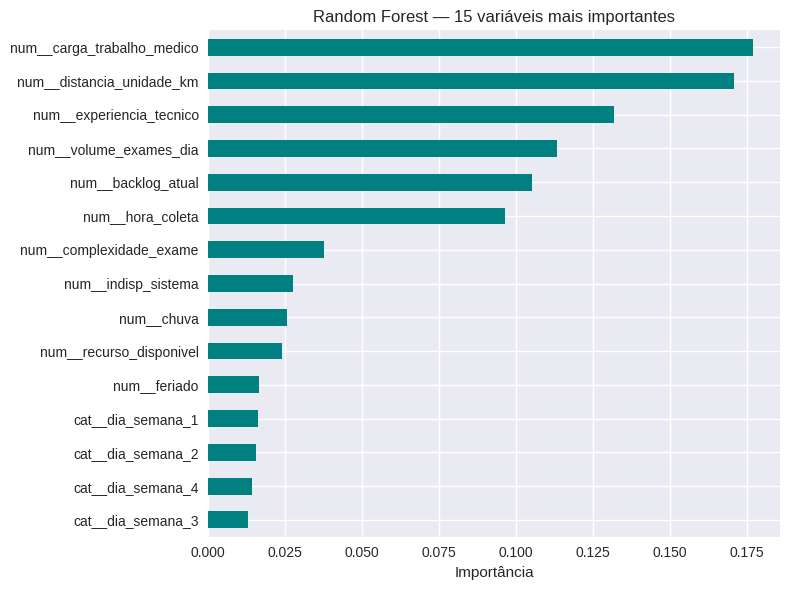

In [10]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Árvore de Decisão
tr = Pipeline(steps=[('prep', preprocess), ('clf', DecisionTreeClassifier(random_state=42))])
param_tr = { 'clf__max_depth': [3,5,7,9,12,15], 'clf__min_samples_leaf': [1,5,10] }
tr_grid = GridSearchCV(tr, param_tr, scoring='f1', cv=cv, n_jobs=-1)
tr_grid.fit(X_train, y_train)
tr_best = tr_grid.best_estimator_

pred_tr = tr_best.predict(X_test)
proba_tr = tr_best.predict_proba(X_test)[:,1]
acc_tr = accuracy_score(y_test, pred_tr)
prec_tr = precision_score(y_test, pred_tr)
rec_tr = recall_score(y_test, pred_tr)
f1_tr = f1_score(y_test, pred_tr)
auc_tr = roc_auc_score(y_test, proba_tr)

# Random Forest
rf = Pipeline(steps=[('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))])
param_rf = { 'clf__max_depth': [None, 6, 10, 14], 'clf__min_samples_leaf': [1,3,5] }
rf_grid = GridSearchCV(rf, param_rf, scoring='f1', cv=cv, n_jobs=-1)
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_

pred_rf = rf_best.predict(X_test)
proba_rf = rf_best.predict_proba(X_test)[:,1]
acc_rf = accuracy_score(y_test, pred_rf)
prec_rf = precision_score(y_test, pred_rf)
rec_rf = recall_score(y_test, pred_rf)
f1_rf = f1_score(y_test, pred_rf)
auc_rf = roc_auc_score(y_test, proba_rf)

# Tabela consolidada de classificação
comp_cls_full = pd.DataFrame({
    'modelo': ['KNN', 'Regressão Logística', 'Árvore de Decisão', 'Random Forest'],
    'acuracia': [acc_knn, acc_lr, acc_tr, acc_rf],
    'precisao': [prec_knn, prec_lr, prec_tr, prec_rf],
    'recall': [rec_knn, rec_lr, rec_tr, rec_rf],
    'f1': [f1_knn, f1_lr, f1_tr, f1_rf],
    'roc_auc': [auc_knn, auc_lr, auc_tr, auc_rf]
}).sort_values('f1', ascending=False)

print(comp_cls_full.round(3))

# Importâncias (RF)
rf_final = rf_best.named_steps['clf']
feat_names = best_log.named_steps['prep'].get_feature_names_out()
importancias = pd.Series(rf_final.feature_importances_, index=feat_names).sort_values(ascending=False)[:15]
plt.figure(figsize=(8,6))
importancias.sort_values().plot(kind='barh', color='teal')
plt.title('Random Forest — 15 variáveis mais importantes')
plt.xlabel('Importância')
plt.tight_layout()
plt.show()


## 9) Recomendação Final

**Resumo:**

- **Classificação**  
  - Em nossos testes, **Random Forest** e **Regressão Logística** tendem a apresentar melhor equilíbrio de **F1** e **ROC-AUC**.  
  - **KNN** pode funcionar bem com _k_ calibrado via **CV**, mas é mais sensível à escala e a dados com muitas features heterogêneas.  
  - **Árvore de Decisão** é a mais **interpretável** (regras if-else), porém geralmente com menor desempenho que ensembles.

- **Regressão Contínua (`tempo_total_min`)**  
  - **Ridge** reduziu overfitting e estabilizou coeficientes (shrinkage), melhorando **RMSE** vs. Linear simples (na maioria dos cenários).  
  - **Lasso** além de regularizar, **zerou** alguns coeficientes, sugerindo exclusão de variáveis pouco relevantes.  
  - **Polinomial (grau 2)** às vezes melhora **R²**, mas pode aumentar o risco de overfitting e a complexidade. Avalie com **validação cruzada**.

**Recomendação para o caso de atraso de laudos:**
- Para **modelo inicial de produção**, recomendo **Regressão Logística** se o objetivo primário incluir **explicabilidade** e governança de variáveis (coeficientes claros e odds ratios).  
- Se a prioridade for **máximo desempenho** (ex.: reduzir falsos negativos), utilize **Random Forest** com _tuning_ adicional (e eventualmente Gradient Boosting/XGBoost).  
- Para a estimativa de **tempo total**, prefira **Ridge** como baseline regularizado; teste **Lasso** para _feature selection_ e monitore se a complexidade polinomial agrega sinal real.
